In [1]:
# importing required libraries
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import joblib
from scipy.stats import zscore
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score,train_test_split,KFold
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso,Ridge,ElasticNet,LinearRegression,SGDRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
# reading data from csv file
scp= pd.read_csv('Advertising.csv')
scp.head(5)

,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


###### Performing EDA

In [3]:
# dropping the index column
scp=scp.drop(['Unnamed: 0'], axis=1)
scp.head(5)

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [4]:
# checking shape of data
scp.shape

(200, 4)

In [5]:
# checking data type
scp.dtypes

TV           float64
radio        float64
newspaper    float64
sales        float64
dtype: object

In [6]:
scp.nunique()

TV           190
radio        167
newspaper    172
sales        121
dtype: int64

In [7]:
# checking null value
scp.isnull().sum()

TV           0
radio        0
newspaper    0
sales        0
dtype: int64

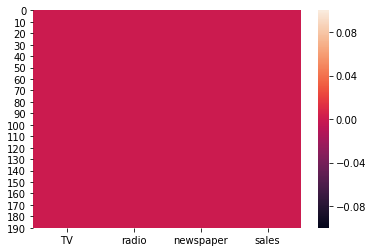

In [8]:
# heatmap of null value
sns.heatmap(scp.isnull())

In [9]:
# checking the data description
scp.describe()

,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


In [10]:
# corelation between coloums
scp.corr()

,TV,radio,newspaper,sales
TV,1.000000,0.054809,0.056648,0.782224
radio,0.054809,1.000000,0.354104,0.576223
newspaper,0.056648,0.354104,1.000000,0.228299
sales,0.782224,0.576223,0.228299,1.000000


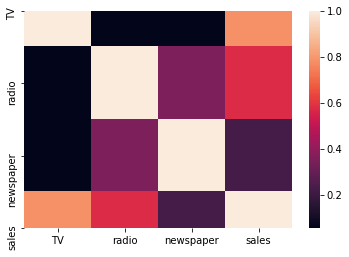

In [11]:
# heat map of corelation
sns.heatmap(scp.corr())

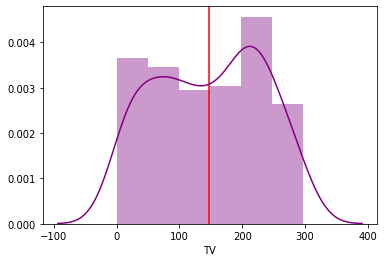

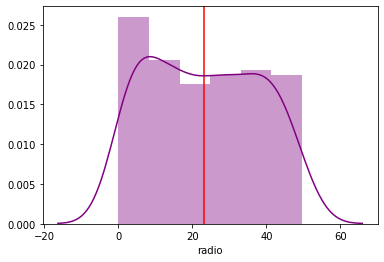

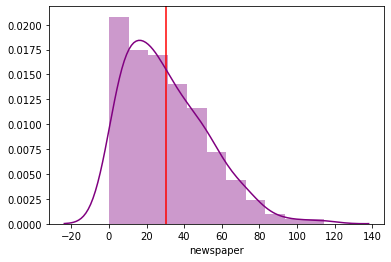

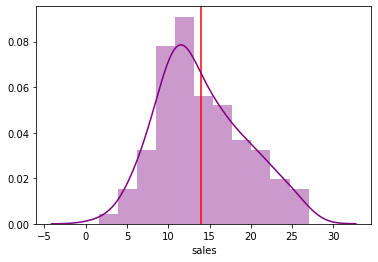

In [12]:
# Histogram - Distribution plot for all continous variables to visualize skewness
for i,col in enumerate(scp):
    plt.figure(i)
    plt.axvline(scp[col].mean(),color = 'r')
    sns.distplot(scp[col],color='purple')

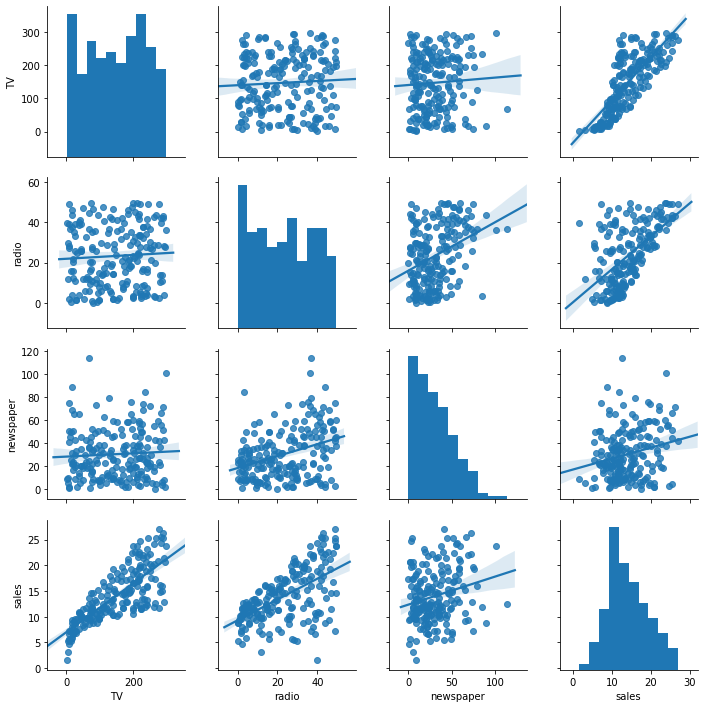

In [13]:
# pair plot to see the scatter of data
sns.pairplot(scp, kind='reg')

TV              AxesSubplot(0.125,0.772143;0.227941x0.107857)
radio        AxesSubplot(0.398529,0.772143;0.227941x0.107857)
newspaper    AxesSubplot(0.672059,0.772143;0.227941x0.107857)
sales           AxesSubplot(0.125,0.642714;0.227941x0.107857)
dtype: object

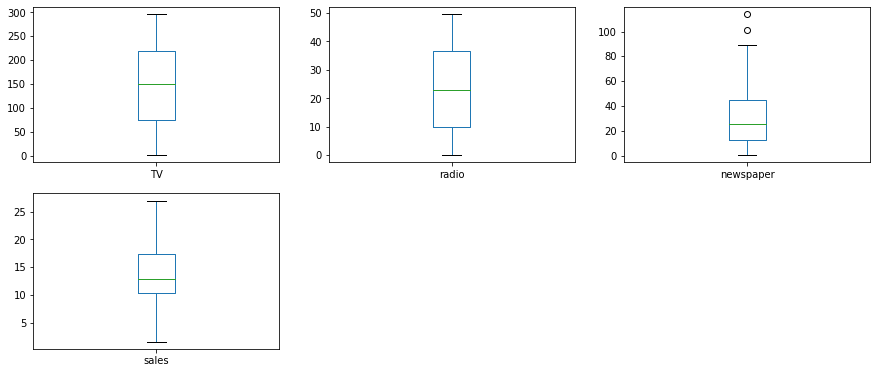

In [14]:
# Creating boxplot of continous variables to visualize the minimum, maximum, avareg value for each colums along with outlires
scp.plot(kind='box',subplots=True,layout=(6,3),figsize=(15,20))

###### Manipulating data before bulding the model

In [15]:
#checking skewness
scp.skew()

TV          -0.069853
radio        0.094175
newspaper    0.894720
sales        0.407571
dtype: float64

In [16]:
#removing skewness
for col in scp.columns:
    if scp.skew().loc[col]>0.55:
        scp[col]=np.sqrt(scp[col])
scp.skew()

TV          -0.069853
radio        0.094175
newspaper    0.062388
sales        0.407571
dtype: float64

In [17]:
#removing outlires
z=abs(zscore(scp))
print(scp.shape)
scp=scp.loc[(z<3).all(axis=1)]
print(scp.shape)

(200, 4)
(200, 4)


In [18]:
# dividing dataset into input values 'x' and output value 'y'
x=scp.iloc[:,0:-1]
print('x dataset\n',x.head(),'\n')
y=scp.iloc[:,-1]
print('y datase\n',y.head())
print(x.shape)
print(y.shape)

x dataset
       TV  radio  newspaper
0  230.1   37.8   8.318654
1   44.5   39.3   6.715653
2   17.2   45.9   8.324662
3  151.5   41.3   7.648529
4  180.8   10.8   7.641989 

y datase
 0    22.1
1    10.4
2     9.3
3    18.5
4    12.9
Name: sales, dtype: float64
(200, 3)
(200,)


In [19]:
# standardizes the data in x using standerd scaler technique
scale=StandardScaler()
x=scale.fit_transform(x)

###### Bulding and comparing multipe model, to find out the best model

In [20]:
#creating models array with all the model
Models=[('Ridge',Ridge()),('GradientBoostingRegressor',GradientBoostingRegressor(random_state=5)),('ElasticNet',ElasticNet()),
        ('Lasso',Lasso()),('SGDRegressor',SGDRegressor()),('DecisionTreeRegressor',DecisionTreeRegressor(random_state=5)),
        ('KNeighborsRegressor',KNeighborsRegressor()),('RandomForestRegressor',RandomForestRegressor(random_state=5)),
        ('LinearRegression',LinearRegression()),('SVR',SVR())]

In [21]:
# loop to find out the maximum r2score for all the model in models array, along a range of random state
Model_array=[]
Random_state=[]
Max_r2score_array=[]
for name,model in Models:
    max_r2score=0    
    for random_state in range(10,99):
        train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=.2,random_state=random_state,shuffle=True)
        model.fit(train_x,train_y)
        pred=model.predict(test_x)
        
        r2score=r2_score(test_y,pred)
        
        if r2score>max_r2score:
            max_r2score=r2score
            best_random_state=random_state
    
    Model_array.append(name)
    Random_state.append(best_random_state)
    Max_r2score_array.append(max_r2score)

In [22]:
# comparing the performances of all the model on R2 score basis
model_accuracy_performance = pd.DataFrame({'Model': Model_array,'R2 score': Max_r2score_array,'Random state': Random_state})
model_accuracy_performance.sort_values(by='R2 score', ascending=False)

,Model,R2 score,Random state
1,GradientBoostingRegressor,0.990718,69
7,RandomForestRegressor,0.989545,47
9,SVR,0.983080,38
5,DecisionTreeRegressor,0.976551,43
6,KNeighborsRegressor,0.970217,38
8,LinearRegression,0.951410,92
0,Ridge,0.951107,92
4,SGDRegressor,0.950434,92
3,Lasso,0.875545,33
2,ElasticNet,0.799433,38


###### Conclusion
On basis of r2 score GradientBoostingRegressor model is performing the best with maximum r2 score

In [23]:
# loop to find out the cross_val_score for r1 of all the model in models array
Cross_val_score_array=[]
Standard_Deviation=[]
for name, model in Models:
    kf=KFold(n_splits=10,random_state=best_random_state)
    cscore=cross_val_score(model,x,y,cv=kf,scoring='r2')
    Cross_val_score_array.append(cscore.mean())
    Standard_Deviation.append(cscore.std())

In [24]:
# comparing the performances of all the model on crossval basis
model_cross_val_performance = pd.DataFrame({'Model': Model_array,'Cross val Acuracy': Cross_val_score_array,
                                            'Standard Deviation': Standard_Deviation})
model_cross_val_performance.sort_values(by='Cross val Acuracy', ascending=False)

,Model,Cross val Acuracy,Standard Deviation
1,GradientBoostingRegressor,0.981399,0.008719
7,RandomForestRegressor,0.975973,0.006617
5,DecisionTreeRegressor,0.948814,0.019096
6,KNeighborsRegressor,0.943296,0.032124
9,SVR,0.914619,0.056608
4,SGDRegressor,0.886077,0.051203
0,Ridge,0.885668,0.052606
8,LinearRegression,0.885560,0.052352
3,Lasso,0.814858,0.061464
2,ElasticNet,0.729914,0.067077


###### Conclusion
On basis of Crossval score for r2 GradientBoostingRegressor model is performing the best with maximum Crossval score

###### On basis of our compression of r2 score and Cross val score i choose GradientBoostingRegressor model since it performing best on given data

In [25]:
#using grid search to improve result for GradientBoostingRegressor model
kfoldr =KFold(n_splits=10,random_state=69)
param_grid={'max_depth':[2,3,4,5,6],'max_features':['auto','sqrt'],'min_samples_split':[2,3,4],'random_state':[5],
            'n_estimators':[50,100,200,300,400,500],'min_samples_leaf':[1,2,3,4]}
mod=GradientBoostingRegressor()
grid=GridSearchCV(estimator=mod,param_grid=param_grid,scoring='r2',cv=kfoldr,n_jobs=3)
grid_result=grid.fit(x,y)

In [26]:
grid_result.best_score_

0.9823598798043232

In [27]:
grid_result.best_params_

{'max_depth': 3,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 200,
 'random_state': 5}

In [28]:
grid_result.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features='auto', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=3, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto', random_state=5,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [29]:
# final model
gbr=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features='auto', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=3, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto', random_state=5,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=.20,random_state=69,shuffle=True)
gbr.fit(train_x,train_y)
pred=gbr.predict(test_x)
score=cross_val_score(gbr,x,y,cv=10,scoring='r2').mean()

print('Model score',gbr.score(train_x,train_y),'\n')
print('R2 score of model is :' ,r2_score(test_y,pred),'\n')
print('The mean of cross_val_score for the model is:',score,'\n')
print('Mean absolute error for model is : ',mean_absolute_error(test_y,pred),'\n')
print('Mean squared error for model is : ',mean_squared_error(test_y,pred),'\n')
print('Root mean squared error for model is : ',np.sqrt(mean_squared_error(test_y,pred)),'\n')

Model score 0.9994626852081866 

R2 score of model is : 0.9902106375803118 

The mean of cross_val_score for the model is: 0.982359879804323 

Mean absolute error for model is :  0.3813069981950288 

Mean squared error for model is :  0.27149303793236185 

Root mean squared error for model is :  0.5210499380408387 



In [30]:
# saving the predection to a csv file.
prediction = pd.DataFrame(pred, columns=['prediction']).to_csv('Project 6 Sales Channel Prediction Case Study.csv')

In [31]:
# saving the model using pickle.
joblib.dump(gbr,'gbr_Project 6 Sales Channel Prediction Case Study.pkl')

['gbr_Project 6 Sales Channel Prediction Case Study.pkl']